In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from imblearn.over_sampling import SMOTE

### Предварительный EDA 🔍
1. **Что за данные?** Это датасет, состоящий из ранжированного списка n объектов на разные поисковые запросы. Каждый объект имеет 78 признаков и параметр, показывающий, кликнул ли пользователь по объекту. В дальнейшем нам понадобится разработать модель бинарной классификации объектов на 2 группы (кликнул/не кликнул), чтобы решить задачу корректного ранжирования объектов по степени их релевантности в каждом поисковом запросе.
2. **Что за типы данных в каждой колонке?** Есть 2 типа данных в колонках: int64 и float64. То есть, для обучения/тестирования модели ничего преобразовывать в дальнейшем не требуется 
3. **Есть ли в данных нулевые/пустые значения?** Нулевых значений нет.
5. **Являются ли данные сбалансированными?** Нет, наблюдается очень сильный перекос (98% vs 2%). Уменьшать 98% без клика до 2% с кликом я не хотел (да это было бы и нелогично), поэтому принял решение использовать SMOTE, прием типа oversampling, генерирующий синтетические данные из миноритарного класса. В таком случае модель обучится на бОльшем количестве данных и будет способна более корректно предсказывать значения.

**Примечание:**  зная, что принятие в расчет проблемы мультиколлинеарности не имееет теоретической целесообразности в данной задаче из-за использования CatBoost, бустинга на деревьях принятия решений, я все же решился удостовериться на практике, не повлияет ли снижение зависимости между переменными на результат. **Спойлер** - поочередное удаление фичей с высоким VIF почти никоим образом не повлияло на предиктивную точность, поэтому данный кусок кода не был включен в файл.

In [2]:
df = pd.read_csv("train_df.csv")
df

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,758,9,0,0,1,20,3,40,0,3,...,0.204682,0.271755,0.055623,0,0,0,0.38648,0.0,0.0,0
1,758,9,0,0,1,20,3,40,0,3,...,0.195531,0.188787,0.036914,0,0,0,0.10982,0.0,0.0,0
2,758,9,0,0,1,20,3,40,0,3,...,0.148609,0.186517,0.027718,0,0,0,0.03674,0.0,0.0,0
3,758,9,0,0,1,20,3,40,0,3,...,0.223748,0.229039,0.051247,0,0,0,0.00000,0.0,0.0,0
4,758,9,0,0,1,20,3,40,0,3,...,0.170935,0.249031,0.042568,0,0,0,0.00000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,494693,9,0,0,0,9,4,38,6,6,...,0.309672,0.921060,0.285226,0,0,0,0.98807,0.0,0.0,0
15077,494693,9,0,0,0,9,4,38,6,6,...,0.303805,0.995086,0.302312,0,0,0,0.87146,0.0,0.0,0
15078,494693,9,0,0,0,9,4,38,6,6,...,0.346538,0.993070,0.344137,0,0,0,0.49999,0.0,0.0,0
15079,494693,9,0,0,0,9,4,38,6,6,...,0.243154,0.994833,0.241898,0,0,0,0.67614,0.0,0.0,0


In [3]:
df[df["search_id"]==2545]

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
47,2545,9,0,0,1,20,4,41,0,0,...,0.240638,0.161402,0.038839,0,0,0,0.20751,0.0,0.0,0
48,2545,9,0,0,1,20,4,41,0,0,...,0.155603,0.177651,0.027643,0,0,0,0.45000,0.0,0.0,0
49,2545,9,0,0,1,20,4,41,0,0,...,0.257623,0.096928,0.024971,0,0,0,0.10866,0.0,0.0,0
50,2545,9,0,0,1,20,4,41,0,0,...,0.268424,0.159566,0.042831,0,0,0,0.00000,0.0,0.0,0
51,2545,9,0,0,1,20,4,41,0,0,...,0.242139,0.152171,0.036846,0,0,0,0.10866,0.0,0.0,0
52,2545,9,0,0,1,20,4,41,0,0,...,0.261134,0.145274,0.037936,0,0,0,0.03674,0.0,0.0,0
53,2545,9,0,0,1,20,4,41,0,0,...,0.428330,0.208514,0.089313,0,0,0,0.85402,0.0,0.0,0
54,2545,9,0,0,1,20,4,41,0,0,...,0.281139,0.129326,0.036359,0,0,0,0.03674,0.0,0.0,0
55,2545,9,0,0,1,20,4,41,0,0,...,0.204358,0.163193,0.033350,0,0,0,0.17614,0.0,0.0,0
56,2545,9,0,0,1,20,4,41,0,0,...,0.218883,0.143369,0.031381,0,0,0,0.10866,0.0,0.0,0


In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [5]:
df.dtypes[df.dtypes == "object"].index.values.tolist()

[]

In [6]:
df.isnull().any().any()

False

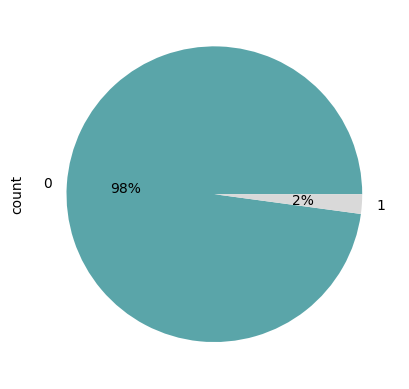

In [7]:
y = df["target"]
x = df.drop(["target", "search_id"], axis = 1)
y.value_counts()

y.value_counts().plot.pie(autopct='%.0f%%', colors=["#5AA5A9", "#D9D9D9"])
plt.show()

In [8]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

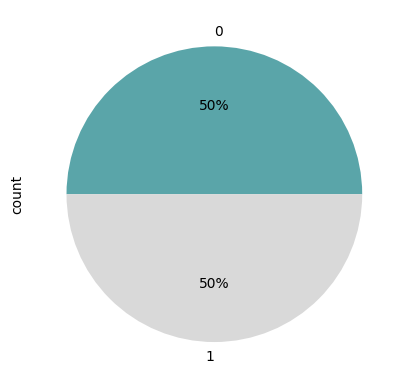

In [9]:
y_smote.value_counts().plot.pie(autopct='%.0f%%', colors=["#5AA5A9", "#D9D9D9"])
plt.show()

### Моделирование 📑
1. **Что за алгоритм был выбран?** CatBoost, современный бустинг-алгоритм от Яндекса, который быстро дает хороший результат на больших/маленьких данных без необходимости кропотливой работы с гиперпараметрами (в любом случае, мы, конечно, попробуем с ними немного поиграть). CatBoost дает дополнительное ускорение при  расчетах на GPU, но на моем компьютере такой опции нет, пришлось довольствоваться CPU
2. **Как были использованы данные?** Классический train_test_split нам, естественно, не нужен, так что используем всю тренировочную выборку для обучения и тестовую - для валидации
3. **Какие гиперпараметры?** Я попробовал дефолтную модель и модель с кастомными гиперпараметрами (взял парочку из разряда самых важных для бустинга с деревьями решений: learning rate, tree depth и l2 регуляризацию, бОльшего количества мой компьютер просто не переваривает). По результатам видно, что лучше взять дефолтные настройки, ведь точность для тренировочного датасета в 100% явно намекает, что что-то не так.
4. **Какая метрика валидации результатов?** точность (R2) - очень понятная и интерпретируемая метрика. Как видно из результатов, точность выше 97% для тестовой и тренировочной выборок, причем разница в сторону переобучения между ними незначительная (~2%).

In [19]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(x_smote, y_smote)

Learning rate set to 0.043718
0:	learn: 0.6723604	total: 26.6ms	remaining: 26.6s
1:	learn: 0.6438341	total: 47.3ms	remaining: 23.6s
2:	learn: 0.6281830	total: 68.3ms	remaining: 22.7s
3:	learn: 0.6114617	total: 87.7ms	remaining: 21.8s
4:	learn: 0.5916391	total: 107ms	remaining: 21.3s
5:	learn: 0.5720448	total: 126ms	remaining: 20.8s
6:	learn: 0.5589931	total: 145ms	remaining: 20.6s
7:	learn: 0.5478076	total: 165ms	remaining: 20.4s
8:	learn: 0.5323130	total: 183ms	remaining: 20.1s
9:	learn: 0.5234352	total: 200ms	remaining: 19.8s
10:	learn: 0.5105698	total: 222ms	remaining: 19.9s
11:	learn: 0.4970999	total: 241ms	remaining: 19.9s
12:	learn: 0.4870544	total: 259ms	remaining: 19.6s
13:	learn: 0.4776760	total: 277ms	remaining: 19.5s
14:	learn: 0.4708105	total: 297ms	remaining: 19.5s
15:	learn: 0.4621474	total: 317ms	remaining: 19.5s
16:	learn: 0.4551708	total: 336ms	remaining: 19.4s
17:	learn: 0.4486686	total: 355ms	remaining: 19.4s
18:	learn: 0.4424665	total: 374ms	remaining: 19.3s
19:	lea

In [20]:
cat.score(x_smote, y_smote)

0.9976963208889491

In [21]:
df_test = pd.read_csv("test_df.csv")
df_test

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,10655,9,0,0,1,20,4,40,0,0,...,0.148830,0.196644,0.029267,0,0,0,0.03674,0.0,0.0,0
1,10655,9,0,0,1,20,4,40,0,0,...,0.119724,0.174199,0.020856,0,0,0,0.00000,0.0,0.0,0
2,10655,9,0,0,1,20,4,40,0,0,...,0.160606,0.198780,0.031925,0,0,0,0.00000,0.0,0.0,0
3,10655,9,0,0,1,20,4,40,0,0,...,0.180191,0.187882,0.033855,0,0,0,0.00000,0.0,0.0,0
4,10655,9,0,0,1,20,4,40,0,0,...,0.117308,0.153586,0.018017,0,0,0,0.00000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,493078,9,0,0,0,9,4,35,0,0,...,0.341683,0.067348,0.023012,0,0,0,0.46108,0.0,0.0,0
1525,493078,9,0,0,0,9,4,35,0,0,...,0.270293,0.049000,0.013244,0,0,0,0.03674,0.0,0.0,0
1526,493078,9,0,0,0,9,4,35,0,0,...,0.372268,0.069882,0.026015,0,0,0,0.14540,0.0,0.0,1
1527,493078,9,0,0,0,9,4,35,0,0,...,0.355755,0.077469,0.027560,0,0,0,0.21288,0.0,0.0,1


In [13]:
dif = (df_test["search_id"].size/df["search_id"].size)*100
print(f"Размер тестовой выборки в {round(dif, 2)} раз меньше тренировочной")

Размер тестовой выборки в 10.14 раз меньше тренировочной


In [22]:
y = df_test["target"]
x = df_test.drop(["target", "search_id"], axis = 1)

model.score(x, y)

0.9777632439502943

In [15]:
model = CatBoostClassifier()
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5]}

grid_search_result = model.grid_search(grid, 
                                       cv=2,
                                       X=x_smote, 
                                       y=y_smote)

0:	learn: 0.6839076	test: 0.6839866	best: 0.6839866 (0)	total: 19.7ms	remaining: 19.7s
1:	learn: 0.6680666	test: 0.6690118	best: 0.6690118 (1)	total: 31ms	remaining: 15.5s
2:	learn: 0.6590801	test: 0.6602851	best: 0.6602851 (2)	total: 44.7ms	remaining: 14.8s
3:	learn: 0.6494724	test: 0.6504568	best: 0.6504568 (3)	total: 55.4ms	remaining: 13.8s
4:	learn: 0.6351872	test: 0.6368734	best: 0.6368734 (4)	total: 66ms	remaining: 13.1s
5:	learn: 0.6252690	test: 0.6275041	best: 0.6275041 (5)	total: 77.4ms	remaining: 12.8s
6:	learn: 0.6180054	test: 0.6200641	best: 0.6200641 (6)	total: 89.1ms	remaining: 12.6s
7:	learn: 0.6111034	test: 0.6132541	best: 0.6132541 (7)	total: 102ms	remaining: 12.6s
8:	learn: 0.6045493	test: 0.6069040	best: 0.6069040 (8)	total: 113ms	remaining: 12.4s
9:	learn: 0.5983731	test: 0.6010990	best: 0.6010990 (9)	total: 124ms	remaining: 12.3s
10:	learn: 0.5849784	test: 0.5885221	best: 0.5885221 (10)	total: 133ms	remaining: 12s
11:	learn: 0.5790446	test: 0.5828201	best: 0.582820

In [16]:
print(f"training: {model.score(x_smote, y_smote)}, \n"
    f"testing {model.score(x, y)}")

training: 1.0, 
testing 0.9777632439502943


### Метрика NDCG 📈
1. Чтобы использовать метрику NDCG, необходимо 2 параметра: y_true (действительные показатели) и y_score (смоделированные показатели). В качестве y_true я взял порядок объектов в каждом поисковом запросе (search_id); в качестве y_score - вероятностную оценку клика на каждый объект (predict_proba).
2. Посчитав NDCG в каждом search_id, я сложил их и разделил на общее количество, т.е. нашел среднее арифметическое
#### Итоговый результат NDCG - **83%**

In [23]:
temp = cat.predict_proba(x)
y_pred = []
for i in temp:
    y_pred.append(i[1])

In [24]:
y_pred = pd.Series(y_pred, name="proba") 
df_pred = pd.concat([df_test["search_id"],y_pred], axis=1)
df_pred

,search_id,proba
0,10655,0.001311
1,10655,0.000703
2,10655,0.011563
3,10655,0.001820
4,10655,0.001045
...,...,...
1524,493078,0.028027
1525,493078,0.002296
1526,493078,0.012953
1527,493078,0.006255


In [25]:
ndcg_overall = []
for id in df_test["search_id"]:
    temp = df_test[df_test["search_id"]==id]
    y_true = np.asarray([[j for j in range(1, len(temp)+1)]])
    scores = np.asarray([df_pred["proba"][df_pred["search_id"]==id]])

    if y_true.ndim > 1 and y_true.shape[1] <= 1:
        pass
    else:
        value = ndcg_score(y_true, scores)
        ndcg_overall.append(value)
    # print(y_true)
    # print(scores)

In [26]:
ndcg_overall
sum(ndcg_overall) / len(ndcg_overall) 

0.8260778800613907